# Fashion-MNIST 데이터 CNN을 통한 이미지 분류

-------------------------------------------------------------------------------------

본 과제에서는 Fashion-MNIST 데이터를 활용하여 CNN 모델을 구축하여 데이터를 학습시켜 모델을 평가하는 과정을 통하여 정확도 확인 및 잘못 분류된 이미지에 대한 분석을 진행한다.

- 1. Fashion-MNIST 데이터셋 로드 및 훈련 데이터, 테스트 데이터로 분할

- 2. 이미지 데이터의 형태 및 클레스 레이블을 시각적 탐색 및 분석 진행

- 3. CNN 모델 구축 (1개의 컨볼루션 레이어, 풀링 레이어 포함)

- 4. 모델 컴파일 및 손실 함수와 최적화 알고리즘 선택 및 구현

- 5. 훈련 데이터를 모델에 학습시키고 학습 과정의 손실과 정확도 모니터링을 통한 확인

- 6. 학습을 완료한 모델에 테스트 데이터를 통해 모델을 평가 후 최종 정확도 보고

- 7. 잘못된 분류 이미지 분석 및 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지 시각화 자료를 통해 확인 진행

총 7단계의 과정을 통해 진행된다.

-------------------------------------------------------------------------------------

# 작업 환경

-------------------------------------------------------------------------------------

- Python Version : 3.10.13


-------------------------------------------------------------------------------------


In [52]:
# 필요한 라이브러리 설치 및 환경 준비

%pip install torchvision # torchvision 라이브러리 설치
%pip install torchinfo # torchinfo 라이브러리 설치
%pip install pytorchcv # pytorchcv 라이브러리 설치

# 데이터셋 읽어오는 모듈
import gzip # 압축된 파일 로드를 위한 모듈
import pickle # 파일를 바이너리로 저장하기 위한 모듈
import numpy as np #numpy (배열 처리)

# CNN 구성
import torch #pytorch import 진행
import torch.nn as nn #신경망을 위한 nn 정의
import torchvision #torchvision
import pytorchcv
import torch.optim as optim #최적화 구현 패키지
import torch.nn.functional as F
import matplotlib.pyplot as plt #시각화를 위한 pyplot
from torchinfo import summary #모델의 구조를 확인 위한 torchinfo
from torch.utils.data import TensorDataset, DataLoader 
#DataLoader : CNN 모델에 생성 시 데이터로 넘겨주는 툴
#TensorDatase : Tensor 데이터를 하나로 합쳐서 새로 만드는 툴
from pytorchcv import plot_results

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name 'plot_results' from 'pytorchcv' (/home/codespace/.python/current/lib/python3.10/site-packages/pytorchcv/__init__.py)

In [21]:
#1. Fashion-MNIST 데이터셋 로드 및 훈련 데이터, 테스트 데이터로 분할

# 이미지 데이터와 클레스 레이블 데이터를 읽어와 변수에 값을 저장
# 바이트 데이터를 np.frombuffer를 통해 numpy 배열로 변경 진행
# reshape를 통해 28 28 형태로 변경 진행 (이미지 픽셀 사이즈)
# torch.from_numpy를 통해 Pytorch의 tensor로 변환하여 저장한다.
with gzip.open("/workspaces/introai202401-midterm-LeeEulHo/t10k-images-idx3-ubyte.gz", 'rb') as f1:
    image_content = f1.read()
image_data = torch.from_numpy((np.frombuffer(image_content, dtype=np.uint8, offset=16)).reshape(-1, 28, 28)).float()
with gzip.open("/workspaces/introai202401-midterm-LeeEulHo/t10k-labels-idx1-ubyte.gz", 'rb') as f2:
    label_content = f2.read()
label_data = torch.from_numpy(np.frombuffer(label_content, dtype=np.uint8, offset=8)).float()

# 위에서 읽은 이미지 데이터와 클래스 데이터를 훈련데이터, 학습데이터로 분할 진행

n=10000 #데이터의 크기를 n으로 미리 지정해두고 하단에서 나누는 비율을 지정할 경우에 사용함

train_image, test_image = np.split(image_data, [n*8//10]) # 80%로 학습 데이터와 테스트 데이터를 나눔
train_label, test_label = np.split(label_data, [n*8//10]) # 80%로 학습 데이터와 테스트 데이터를 나눔

# 나눠진 데이터셋을 tensorDataset을 통해 하나로 묶어줌

train_dataset = TensorDataset(train_image, train_label)
test_dataset = TensorDataset(test_image, test_label)


# loader를 생성하여 모델 생성 시 넣어주는 기능을 미리 구현
# batch_size : 자료 크기, shuffle : 섞는지 여부, num_workers : 프로세서 수, drop_last : 묶은 나머지 데이터 버림 여부
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)


이미지 데이터의 형태: torch.Size([10000, 28, 28])
레이블 데이터의 형태: torch.Size([10000])


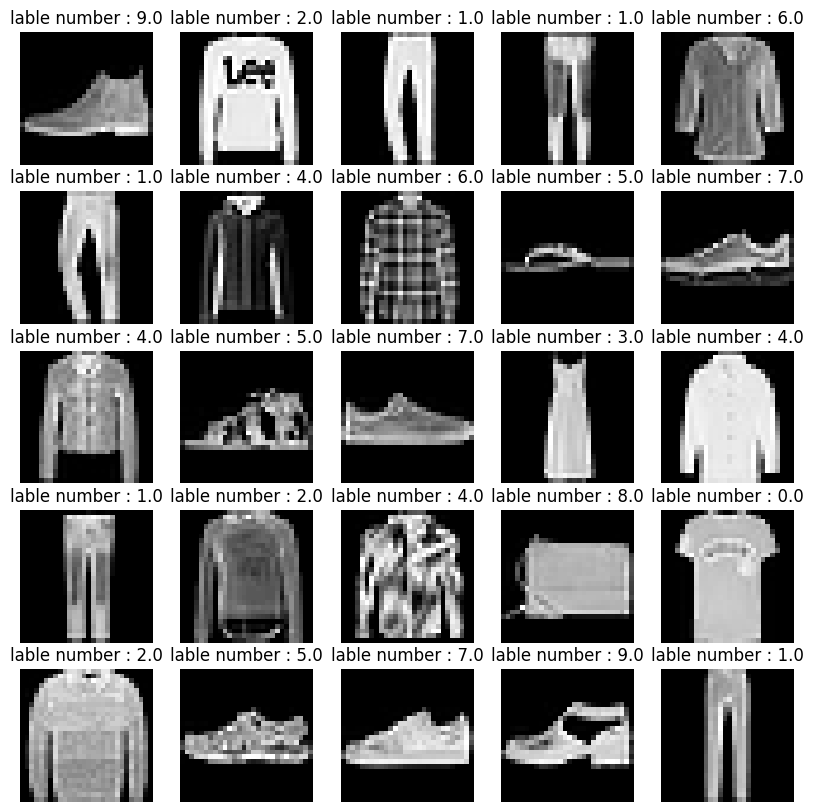

클래스 레이블 종류 :  tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


In [22]:
#2. 이미지 데이터의 형태 및 클레스 레이블을 시각적 탐색 및 분석 진행

# 읽은 데이터의 형태 출력
print("이미지 데이터의 형태:", image_data.shape)
print("레이블 데이터의 형태:", label_data.shape)

# 25개 이미지를 출력
# sampleing을 통해 어떤 클래스 레이블이 어떤 이미지에 해당하는지를 확인 가능하다.
# 0 : T-shirt/top, 1 : Trouser, 2 : Pullover, 3 : Dress, 4 : Coat, 5 : Sandal, 6 : Shirt, 7 : Sneaker, 8 : Bag, 9 : Ankel boot
plt.figure(figsize=(10, 10)) # 10x10크기로 지정
for i in range(25): # 25개
    plt.subplot(5, 5, i+1) # 겹치지 않게 5 5 배열로 생성
    plt.imshow(image_data[i], cmap='gray') # 이미지 출력
    plt.title(f"lable number : {label_data[i].item()}") # 해당 레이블 번호 입력
    plt.axis('off') # 세부적인 눈금은 없앰
plt.show()

# label의 값이 어떤 종류로 있는지 중복값을 unique()를 이용하여 소거 후 확인
labels_list = torch.unique(label_data)
print("클래스 레이블 종류 : ", labels_list)

In [42]:
#3. CNN 모델 구축 (1개의 컨볼루션 레이어, 풀링 레이어 포함)

# CNN 모델 클래스를 정의한다
class OneConv(nn.Module): # OneConv 클래스를 nn.Module을 상속 받아 신경망을 생성한다.
    def __init__(self): # 객체 생성 시 초기에 호출되며 초기화를 진행한다.
        super(OneConv, self).__init__()  # 생성자 호출 및 초기화 진행
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5,5))  # 2D 합성곱 레이어를 정의해서 conv에 할당
        self.flatten = nn.Flatten(9*24*24, 10) # Flatten 레이어를 생성 후 flatten에 할당
        self.fc = nn.Linear(5184, 10)  # 선형 레이어 생성 후 fc에 할당, 5184개의 특성을 10개로
    def forward(self, x):  # 데이터가 입력시 들어가는 통로로 순전파라고 칭함 
        if x.dim() == 5 and x.size(2) == 1:  # 예측하지 못한 추가 차원의 여부가 있을 경우
            x = x.squeeze(2)  # 해당 차원 제거 실행
        
        x = nn.functional.relu(self.conv(x)) # x에 self.conv를 적용 후 reul 함수(X가 양수면 통과, 음수면 0) 적용
        x = self.flatten(x)  # 출력에 Flatten 레이어를 적용하여 하나의 벡터로 표현
        x = nn.functional.log_softmax(self.fc(x), dim=1)  # 벡터 x에 self.fc를 적용 후 log_softmax 함수(확률 계산)를 적용
        
        return x  # 최종 값을 반환

# CNN 모델 생성
net = OneConv()

# 생성된 CNN 모델의 구조 요약 출력
summary(net,input_size=(64,1,28,28))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1]

In [43]:
#4. 모델 컴파일 및 손실 함수와 최적화 알고리즘 선택 및 구현

def train(model, train_loader, test_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target)
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
    return history


In [44]:
#5. 훈련 데이터를 모델에 학습시키고 학습 과정의 손실과 정확도 모니터링을 통한 확인

hist = train(net, train_loader, test_loader, epochs=5)
if hist is None:
    print("Training did not return any history.")
else:
    plot_results(hist)

An error occurred: Given groups=1, weight of size [9, 1, 5, 5], expected input[1, 64, 28, 28] to have 1 channels, but got 64 channels instead
Training did not return any history.


In [45]:
#6. 학습을 완료한 모델에 테스트 데이터를 통해 모델을 평가 후 최종 정확도 보고


In [ ]:
#7. 잘못된 분류 이미지 분석 및 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지 시각화 자료를 통해 확인 진행


In [7]:
import torch.nn as nn
%pip install torchsummary
from torchsummary import summary

class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        # 2D 합성곱 레이어를 정의합니다.
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5,5))
        
        # Flatten 레이어를 생성합니다.
        self.flatten = nn.Flatten()
        
        # 완전 연결 레이어를 정의합니다.
        self.fc = nn.Linear(5184, 10)

    def forward(self, x):
        # 입력 텐서의 차원을 확인하고, 예상치 못한 추가 차원이 있는지 확인합니다.
        if x.dim() == 5 and x.size(2) == 1:
            x = x.squeeze(2)
        
        # 합성곱 레이어와 ReLU 활성화 함수를 적용합니다.
        x = nn.functional.relu(self.conv(x))
        
        # Flatten 레이어를 통해 출력을 1차원 배열로 변환합니다.
        x = self.flatten(x)
        
        # 완전 연결 레이어와 log softmax 활성화 함수를 적용합니다.
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        
        return x

# 네트워크의 인스턴스를 생성합니다.
net = OneConv()

# 모델의 요약 정보를 출력합니다.
summary(net, input_size=(1, 1, 28, 28))


Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


Epoch  0, Train acc=0.949, Val acc=0.974, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.980, Val acc=0.976, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.987, Val acc=0.976, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.987, Val acc=0.979, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.990, Val acc=0.976, Train loss=0.000, Val loss=0.001


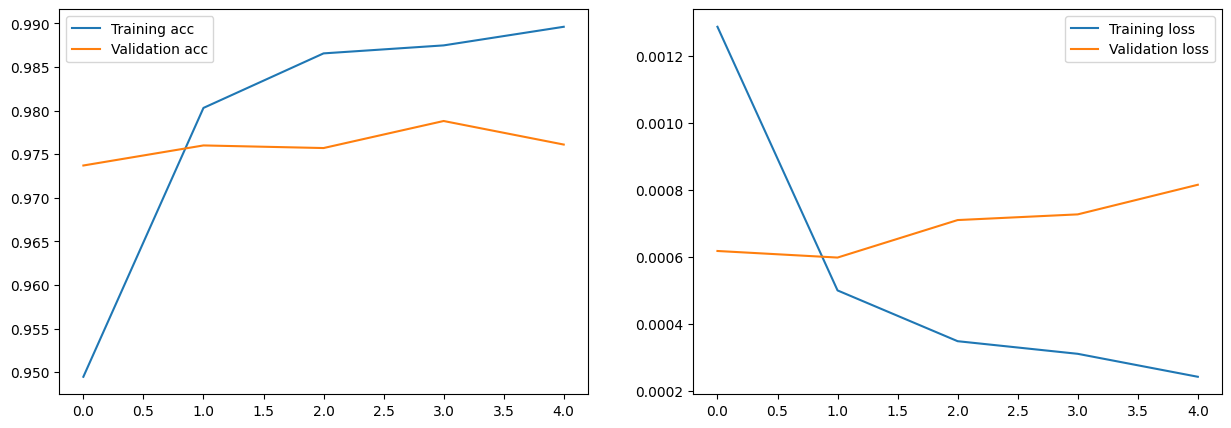

In [11]:
'''hist = train(net,train_loader,test_loader,epochs=5)
if hist is None:
    print("Training did not return any history.")
else:
    plot_results(hist)'''